## Supervised learning assignemtn
##### Name: Daan Steur
##### Studentnumber: 379943
##### Supervisor: Drs. Fenna Feenstra
##### Course: DSLS Data Science 3: Unsupervised learning
##### Date: 27th of may

## Prediction of health parameters based on patient informatio. 

### Assignment 
Choose one of the assignments (beginners, intermediate, advanced). Note that each of the assignments can lead to a sufficient mark, you should just choose the one you like the most. If you do not like one of the assignments, you can use your own dataset as well. Just make sure that you explain your choices! 

### Data source
Read the two datasets in and conduct proper preprocessing. Combine the clinical data with the genetic data. Use unsupervised learning to develop an accurate machine learning model that can predict lung cancer. Explain your choices. Make sure you properly inspect and preprocess the data. (Check for missing data, skewness, distribution, sample, linearity, correlations etc.). Use an argumentative approach. 
clinical meta data: https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2

Gene Expression data: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/


Loading data and packages

In [19]:
# load packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns



In [26]:
# load data
url = "https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2"
meta = pd.read_excel(url)
# meta.head()

# read in genetic data
data = pd.read_table('data/GSE58661_series_matrix.txt.gz', sep='\t', header=61, index_col=0,quotechar='"', compression='gzip')
# remove last column with end of table text
data.drop(index=data.index[-1], 
        axis=0, 
        inplace=True)
data.head()

,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,GSM1416537,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
ID_REF,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-3_at,7.376915,8.024915,7.522543,7.152864,7.211031,7.704962,7.779374,7.136893,7.160221,8.141578,...,7.611992,7.345206,7.316975,7.418340,7.756286,7.215856,7.465109,7.245458,7.039592,7.393667
AFFX-BioB-5_at,6.984530,7.427048,7.077207,6.849513,6.753131,7.195947,7.429800,6.745630,6.751358,7.632631,...,7.175015,7.014479,6.913879,6.898449,7.347570,6.740992,7.080787,6.725812,6.575376,7.041106
AFFX-BioB-M_at,7.330576,8.010530,7.334551,7.143286,7.077163,7.753484,7.712429,7.036303,7.089186,7.992361,...,7.612393,7.285821,7.324635,7.408880,7.745624,7.152722,7.422373,7.263596,6.975162,7.366620
AFFX-BioC-3_at,10.922741,11.390638,10.936703,10.791909,10.701328,11.221732,11.084229,10.588372,10.628909,11.412668,...,11.097486,10.908682,10.781228,10.935723,11.200635,10.707980,10.736531,10.770440,10.367009,10.753221
AFFX-BioC-5_at,11.032030,11.533338,11.018510,10.875259,10.823792,11.276973,11.178643,10.700420,10.779332,11.470336,...,11.265739,10.990373,10.900765,11.101546,11.343329,10.842697,10.900509,10.838008,10.494806,10.863600


In [28]:
meta

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,Homo sapiens,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available,total RNA,biotin,GPL15048
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,Homo sapiens,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,Homo sapiens,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available,total RNA,biotin,GPL15048
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,LUNG3-85,lung_85,LUNG3-85.CEL,Right Upper Lobe,Homo sapiens,M,"Adenocarcinoma, Acinar Type",2.2,pT1b,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048
85,LUNG3-86,lung_86,LUNG3-86.CEL,Right Upper Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",5.0,pT3,PN2,pM0,Primary,3,total RNA,biotin,GPL15048
86,LUNG3-87,lung_87,LUNG3-87.CEL,Right Middle Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, Papillary",3.5,pT2,pN0,pM0,Primary,2,total RNA,biotin,GPL15048
87,LUNG3-88,lung_88,LUNG3-88.CEL,Right Upper Lobe,Homo sapiens,M,"Non-Small Cell, Pleomorphic Type",8.5,pT3,pN0,pM0,Primary,Not Available,total RNA,biotin,GPL15048


Data exploration

,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,GSM1416537,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
count,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,...,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000,60607.000000
mean,5.680573,5.700623,5.675822,5.675058,5.677978,5.682064,5.683734,5.678165,5.676885,5.694553,...,5.681162,5.673242,5.667740,5.680530,5.689509,5.676860,5.682147,5.670483,5.667624,5.687026
std,2.558558,2.489822,2.534585,2.566710,2.525269,2.509330,2.496340,2.563827,2.576636,2.510412,...,2.566349,2.553281,2.576063,2.573093,2.520094,2.568826,2.539893,2.588632,2.574080,2.527894
min,1.082310,1.231677,1.171192,1.120783,1.165790,1.177303,1.093046,1.112178,1.208737,1.257494,...,1.154569,1.127033,1.163454,1.136984,1.141719,1.067227,1.199240,1.219847,1.207234,1.228052
25%,3.558923,3.686416,3.617810,3.557044,3.623637,3.653428,3.671885,3.569945,3.517107,3.637107,...,3.547411,3.580269,3.525356,3.537163,3.634539,3.537201,3.602213,3.510174,3.532404,3.623046
50%,5.357941,5.380131,5.355157,5.357269,5.361109,5.396275,5.321336,5.366390,5.398493,5.381028,...,5.386678,5.364888,5.378093,5.387265,5.386115,5.396810,5.369928,5.351684,5.343236,5.402504
75%,7.562217,7.498489,7.515259,7.576710,7.497784,7.474284,7.462005,7.568927,7.594420,7.524313,...,7.583958,7.537180,7.559441,7.605293,7.514806,7.565555,7.524894,7.606423,7.574086,7.508896
max,14.770915,14.754608,14.756939,14.771076,14.767731,14.743634,14.742481,14.770167,14.754608,14.754608,...,14.789281,14.772959,14.781435,14.754608,14.772048,14.742481,14.754608,14.738343,14.728676,14.768745


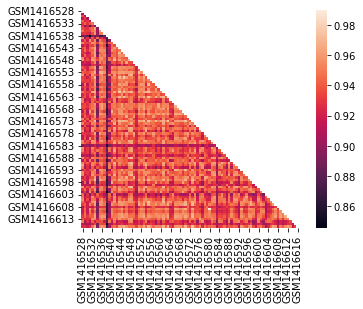

In [22]:
# Calculate correlation between each pair of variable
corr_matrix=data.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True)
data.describe()


In [29]:
meta.head()

,sample.name,title,CEL.file,source.location,organism,characteristics.tag.gender,characteristics.tag.histology,characteristics.tag.tumor.size.maximumdiameter,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,characteristics.tag.primaryVSmets,characteristics.tag.grade,molecule tested,label,platform
0,LUNG3-01,lung_1,LUNG3-01.CEL,Left Lower Lobe,Homo sapiens,M,"Squamous Cell Carcinoma, NOS",4.0,pT2,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
1,LUNG3-02,lung_2,LUNG3-02.CEL,Left Lower Lobe,Homo sapiens,M,"Adenocarcinoma, Papillary, NOS",1.3,pT1,pNX,pMX,Primary,Not Available,total RNA,biotin,GPL15048
2,LUNG3-03,lung_3,LUNG3-03.CEL,Left Lower Lobe,Homo sapiens,M,Non-Small Cell,11.0,pT3,pN0,pM0,Primary,3,total RNA,biotin,GPL15048
3,LUNG3-04,lung_4,LUNG3-04.CEL,Left Lower Lobe,Homo sapiens,M,"Papillary Type AND Adenocarcinoma, Bronch...",NaN,pTX,pNx,pM1,Primary,Not Available,total RNA,biotin,GPL15048
4,LUNG3-05,lung_5,LUNG3-05.CEL,Left Lower Lobe,Homo sapiens,F,"Squamous Cell Carcinoma, NOS",7.8,pT3,pN0,pM0,Primary,2,total RNA,biotin,GPL15048


Data Explanation

Data prep

Clustering

Fine tunning